In [23]:
from lsh import *
from utils import *
from query import *

%load_ext autoreload
%autoreload 2

PATH_IMGS     = "imnet-val/val/"
FILE_FEATURES = "imnet-val/cnn-5000.p"
FNAME_OFFSET  = 48 #prefix of stored file names to chop off
IMSIZE        = (224, 224)

data = dataset(FILE_FEATURES,PATH_IMGS,IMSIZE,normalize=True,fname_offt=FNAME_OFFSET)

PATH_IMGS     = "imnet-test-1000/imgs/"
FILE_FEATURES = "imnet-test-1000/cnn-1000.p"
FNAME_OFFSET  = 23 #prefix of stored file names to chop off
IMSIZE        = (224, 224)
queries = dataset(FILE_FEATURES,PATH_IMGS,IMSIZE,normalize=True,fname_offt=FNAME_OFFSET)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
b = 200 #hash bits
M = 30  #number of permutations

query_obj = query(data=data, queries_dataset=queries, hash_bits=b, 
                  permutations=M)

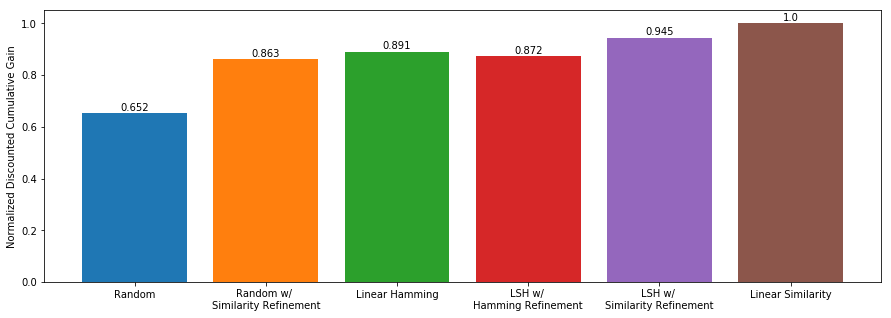

0.0015286850929260255


In [67]:
L = 4   #number of neighbors to make candidates
k = 10  #top-k nearest neighbors
N_queries = 100

t, ndgc = query_obj.time_and_compare(N_queries, N_neighbor_candidates=L, k_report=k)
query_obj.ndgc_plot()
print(t, ndgc)

In [114]:
k = 10  #top-k nearest neighbors
N_queries = 100


Ls = [4] #number of neighbors to make candidates
bs = [200] #hash bits
es = [2.7] #error tolerance

Ls = [0, 2, 4, 8] #number of neighbors to make candidates
bs = [20, 80, 200, 600] #hash bits
es = [4, 2.7, 2.1, 1.5] #error tolerance

ts = np.zeros((len(bs), len(es), len(Ls)))
ndgcs = np.zeros((len(bs), len(es), len(Ls)))
print("{:>5}, {:>5}, {:>5}, {:>5}, {:>8}, {:>8}".format("b", "eps", "M", "L", "t (msec)", "ndgc"))
for b_idx,b in enumerate(bs):
    for e_idx,e in enumerate(es):
        n = data.X.shape[1]
        M = round(2*n**(1/(1+e)))
        query_obj = query(data=data, queries_dataset=queries, hash_bits=b, 
                          permutations=M)
        
        for l_idx,L in enumerate(Ls):
            t, ndgc = query_obj.time_and_compare(N_queries, N_neighbor_candidates=L, k_report=k)
            ts[b_idx,e_idx,l_idx] = t
            ndgcs[b_idx,e_idx,l_idx] = ndgc
            print("{:5d}, {:5.1f}, {:5d}, {:5d}, {:8.3f}, {:8.3f}".format(b, e, M, L, t*1000, ndgc))


    b,   eps,     M,     L, t (msec),     ndgc
   20,   4.0,    11,     0,    0.512,    0.531
   20,   4.0,    11,     2,    0.525,    0.808
   20,   4.0,    11,     4,    0.569,    0.841
   20,   4.0,    11,     8,    0.701,    0.873
   20,   2.7,    20,     0,    0.763,    0.607
   20,   2.7,    20,     2,    0.803,    0.852
   20,   2.7,    20,     4,    0.873,    0.880
   20,   2.7,    20,     8,    1.113,    0.912
   20,   2.1,    31,     0,    1.093,    0.626
   20,   2.1,    31,     2,    1.193,    0.869
   20,   2.1,    31,     4,    1.323,    0.896
   20,   2.1,    31,     8,    1.425,    0.926
   20,   1.5,    60,     0,    1.651,    0.635
   20,   1.5,    60,     2,    1.628,    0.893
   20,   1.5,    60,     4,    1.823,    0.920
   20,   1.5,    60,     8,    2.862,    0.944
   80,   4.0,    11,     0,    0.526,    0.727
   80,   4.0,    11,     2,    0.583,    0.857
   80,   4.0,    11,     4,    0.647,    0.889
   80,   4.0,    11,     8,    0.744,    0.914
   80,   2.7,

---

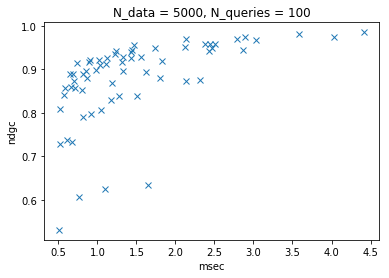

In [119]:
plt.plot(ts.flatten()*1000, ndgcs.flatten(), 'x')
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = 5000, N_queries = 100')
plt.show()


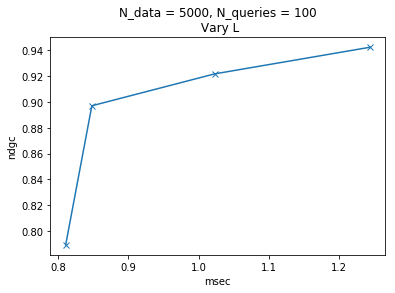

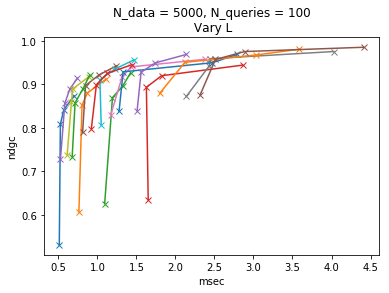

In [135]:
plt.plot(ts[1, 1,:]*1000, ndgcs[1, 1,:], 'x-')
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = 5000, N_queries = 100\n Vary L')
plt.show()

for b_idx, b in enumerate(bs):
    for e_idx, e in enumerate(es):
        plt.plot(ts[b_idx, e_idx, :]*1000, ndgcs[b_idx, e_idx, :], 'x-')
        
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = 5000, N_queries = 100\n Vary L')
plt.show()

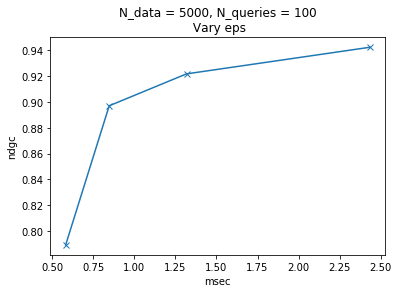

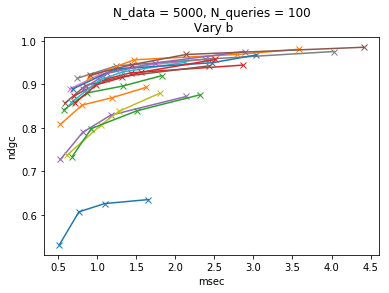

In [133]:
plt.plot(ts[1, :,1]*1000, ndgcs[1, 1,:], 'x-')
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = 5000, N_queries = 100\n Vary eps')
plt.show()

for b_idx, b in enumerate(bs):
    for l_idx, L in enumerate(Ls):
        plt.plot(ts[b_idx, :, l_idx]*1000, ndgcs[b_idx, :, l_idx], 'x-')
        
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = 5000, N_queries = 100\n Vary eps')
plt.show()

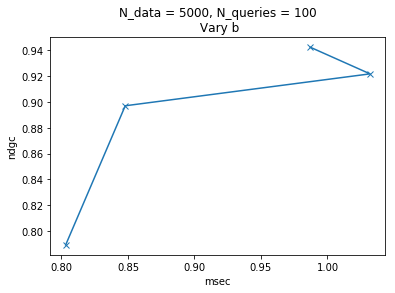

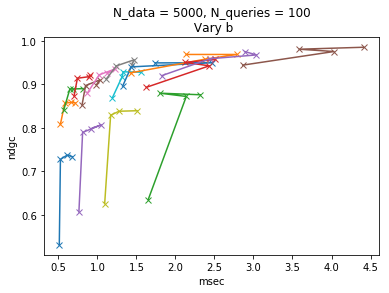

In [134]:
plt.plot(ts[:, 1,1]*1000, ndgcs[1, 1,:], 'x-')
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = 5000, N_queries = 100\n Vary b')
plt.show()

for e_idx, e in enumerate(es):
    for L_idx, L in enumerate(Ls):
        plt.plot(ts[:, e_idx, L_idx]*1000, ndgcs[:, e_idx, L_idx], 'x-')
        
plt.xlabel('msec')
plt.ylabel('ndgc')
plt.title('N_data = 5000, N_queries = 100\n Vary b')
plt.show()

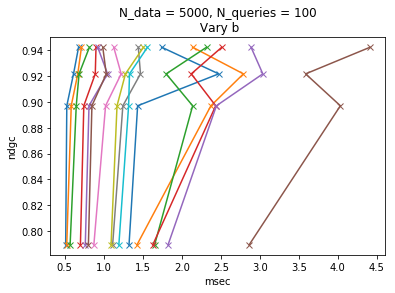